# Facial Expression Recognition

This model will categorize faces based on the facial expressions.<br>
The output can be one of the six categories: 0=Angry, 1=Fear, 2=Happy, 3=Sad, 4=Surprise, 5=Neutral <br>
The model will be used in PEPPER robot in order to help him interact better with humans while playing a game of cards.

In [14]:
# Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0-preview
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
assert tf.__version__ >= "2.0"

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

## 1. Data Preparation

The data are in fer2013.csv file which saves them in three columns: emotion, pixels, Usage. <br>
The data is divided into three categories: for training, for validation and for testing. Then, processed for the deep learning model.

In [16]:
(trainImages, trainLabels) = ([], [])
(valImages, valLabels) = ([], [])
(testImages, testLabels) = ([], [])

In [17]:
data = open(r'C:\Users\Shend\Desktop\Tema\fer2013.csv')
data.__next__()

'emotion,pixels,Usage\n'

In [18]:
for row in data:
    (label, image, usage) = row.strip().split(",")
    label = int(label)
    if label == 1:
        label = 0
    if label > 0:
        label -= 1
    
    image = np.array(image.split(" "), dtype="uint8")
    image = image.reshape((48, 48))
    
    if usage=="Training":
        trainImages.append(image)
        trainLabels.append(label)
    elif usage=="PrivateTest":
        valImages.append(image)
        valLabels.append(label)
    elif usage=="PublicTest":
        testImages.append(image)
        testLabels.append(label)

In [19]:
print("Number of Train Images and Train Labels: ", len(trainImages), len(trainLabels))
print("Number of Validation Images and Validation Labels: ", len(valImages), len(valLabels))
print("Number of Test Images and Test Labels: ", len(testImages), len(testLabels))

Number of Train Images and Train Labels:  28709 28709
Number of Validation Images and Validation Labels:  3589 3589
Number of Test Images and Test Labels:  3589 3589


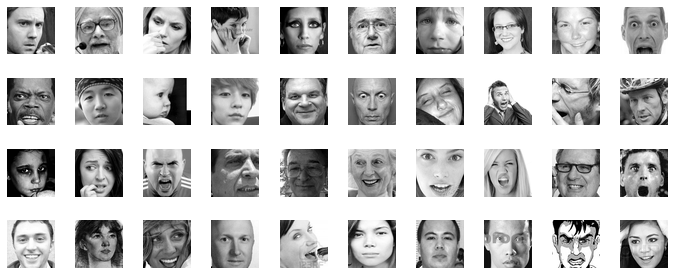

In [20]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(trainImages[index],cmap='gray', interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [21]:
trainImages = np.asarray(trainImages)
valImages = np.asarray(valImages)
testImages = np.asarray(testImages)

In [22]:
trainLabels = np.asarray(trainLabels)
valLabels = np.asarray(valLabels)
testLabels = np.asarray(testLabels)

In [23]:
trainImages = trainImages / 255.
valImages = valImages / 255.
testImages = testImages / 255.

In [24]:
trainImages = trainImages[..., np.newaxis]
valImages = valImages[..., np.newaxis]
testImages = testImages[..., np.newaxis]

In [25]:
testImages.shape

(3589, 48, 48, 1)

In [26]:
type(testImages)

numpy.ndarray

# 2. Pruned Model

The model is trained for 100 epochs(with early stopping) and a batch size of 128 samples. <br>
The model is pruned in order to be more space and energy efficient. <br>
This is done because we need a lighter model in PEPPER robot, considering that it has a limited computational power. <br>

In [27]:
epochs = 100
batch_size = 128
num_train_samples = trainImages.shape[0]
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs
print('End step: ' + str(end_step))

End step: 22500


In [28]:
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow import keras
from tensorflow.keras import layers
import keras.regularizers as regularizers

pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.4,
                                                   final_sparsity=0.7,
                                                   begin_step=5000,
                                                   end_step=end_step,
                                                   frequency=1000)
}

the_model = tf.keras.Sequential([
              sparsity.prune_low_magnitude(
                  layers.Conv2D(filters=64, input_shape=(48, 48, 1), kernel_size=(3,3),
                                strides=(1,1), padding="same", 
                                kernel_initializer="he_normal",
                                kernel_regularizer=regularizers.l2(0.001),
                               activity_regularizer=regularizers.l2(0.001)),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              
              sparsity.prune_low_magnitude(
                  layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same",
                                kernel_initializer="he_normal",
                                kernel_regularizer=regularizers.l2(0.001),
                                activity_regularizer=regularizers.l2(0.001)),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              layers.MaxPool2D(pool_size=2),
              layers.Dropout(0.5),

    
              sparsity.prune_low_magnitude(
                  layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same",
                                kernel_initializer="he_normal",
                                kernel_regularizer=regularizers.l2(0.001),
                               activity_regularizer=regularizers.l2(0.001)),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              
              sparsity.prune_low_magnitude(
                 layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1),
                               padding="same", kernel_initializer="he_normal",
                               kernel_regularizer=regularizers.l2(0.001),
                               activity_regularizer=regularizers.l2(0.001)),
                 **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              layers.MaxPool2D(pool_size=2),
              layers.Dropout(0.5),

    
              sparsity.prune_low_magnitude(
                 layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),
                               padding="same", kernel_initializer="he_normal",
                               kernel_regularizer=regularizers.l2(0.001),
                               activity_regularizer=regularizers.l2(0.001)),
                 **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              
              sparsity.prune_low_magnitude(
                 layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),
                               padding="same", kernel_initializer="he_normal",
                               kernel_regularizer=regularizers.l2(0.001),
                               activity_regularizer=regularizers.l2(0.001)),
                 **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              layers.MaxPool2D(pool_size=2),
              layers.Dropout(0.5),
              
              layers.Flatten(),
              sparsity.prune_low_magnitude(
                layers.Dense(units=256, activation="relu", kernel_initializer="he_normal"),
                **pruning_params),
              layers.BatchNormalization(),
              layers.Dropout(0.5),
              
              sparsity.prune_low_magnitude(
                  layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Dropout(0.5),
                
              sparsity.prune_low_magnitude(
                 layers.Dense(units=6, activation="softmax", kernel_initializer="he_normal"),
                 **pruning_params)
              ])

Using TensorFlow backend.


Instructions for updating:
Please use `layer.add_weight` method instead.


In [29]:
the_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 48, 48, 64)        1218      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 48, 48, 64)        73794     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0

In [43]:
opt = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999,epsilon=1e-7)
the_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=30)
mc = ModelCheckpoint('FER.h5', monitor='val_accuracy', mode='max', save_best_only=True)
s = sparsity.UpdatePruningStep()

In [45]:
history = the_model.fit(trainImages, trainLabels, epochs=epochs, validation_data=[valImages, valLabels],
                        batch_size=batch_size, callbacks=[es, mc, s],steps_per_epoch=len(trainImages) // batch_size)

Train on 28709 samples, validate on 3589 samples
Epoch 1/100
28581/28709 [============================>.] - ETA: 0s - loss: 0.9584 - accuracy: 0.7312 - val_loss: 1.1378 - val_accuracy: 0.6751

In [80]:
prediction = the_model.evaluate(testImages, testLabels, batch_size=128)

3589/3589 [==============================] - 1s 358us/sample - loss: 1.1992 - accuracy: 0.6565


In [91]:
final_model = sparsity.strip_pruning(the_model)
final_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_33 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_24 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_34 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_25 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 24, 24, 64)       

In [92]:
tf.keras.models.save_model(final_model, 'FER_pruned.h5', include_optimizer=True)

In [30]:
new_model = tf.keras.models.load_model('FER_pruned.h5')
opt = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999,epsilon=1e-7)
new_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [31]:
new_model.evaluate(testImages, testLabels, batch_size=128)

3589/3589 [==============================] - 3s 966us/sample - loss: 104.0224 - accuracy: 0.6565


[104.02237392541392, 0.6564503]

## 3. Model Evaluation

### 3.1 Accuracy and Loss

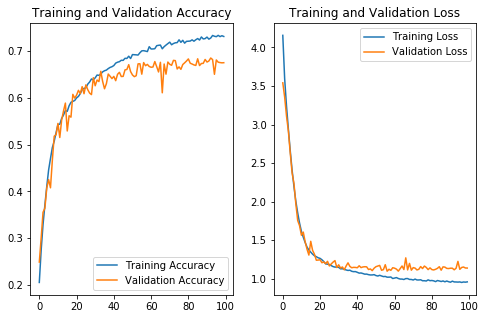

In [93]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 3.2 Confusion Matrix

In [36]:
y_pred = new_model.predict(testImages)
y_pred_c =np.argmax(y_pred, axis=1)

In [39]:
confusion_matrix = tf.math.confusion_matrix(testLabels, y_pred_c, num_classes=6)
confusion_matrix

<tf.Tensor: shape=(6, 6), dtype=int32, numpy=
array([[354,  29,  22,  49,  19,  50],
       [ 74, 186,  18, 101,  60,  57],
       [ 15,  13, 753,  20,  26,  68],
       [ 93,  72,  22, 320,  17, 129],
       [ 10,  23,  18,   3, 355,   6],
       [ 49,  37,  47,  73,  13, 388]])>

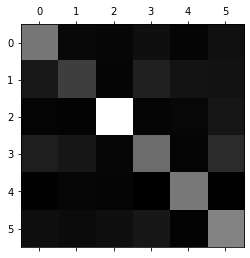

In [40]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plt.matshow(confusion_matrix, cmap=plt.cm.gray)
plt.show()